<a href="https://colab.research.google.com/github/anupstar100/UML-Capston_Project-Customer_Segmentation/blob/main/UML_Capston_Project_Online_Retail_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [4]:
# MOUNTING THE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# IMPORTING THE REQUIRED LIBRARIES
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [6]:
# LOADING OUR DATA
df = pd.read_csv('/content/drive/MyDrive/Capston Project/Online Retail Customer Segmentation/Online Retail (1).csv', encoding = "ISO-8859-1")

### Glimpses of our data

In [7]:
# FIRST FIVE ROWS
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [8]:
# LAST FIVE ROWS
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


In [9]:
# RANDOM FIVE ROWS
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
406253,571745,23162,REGENCY TEA STRAINER,4,19-10-2011 10:48,3.75,14911.0,EIRE
230279,557130,21213,PACK OF 72 SKULL CAKE CASES,24,17-06-2011 08:09,0.55,14005.0,United Kingdom
222782,556459,22182,CAKE STAND VICTORIAN FILIGREE SMALL,1,10-06-2011 17:25,4.13,NaN,United Kingdom
253419,559163,21200,MULTICOLOUR HONEYCOMB PAPER GARLAND,1,06-07-2011 16:33,3.29,NaN,United Kingdom
211998,555403,47566B,TEA TIME PARTY BUNTING,4,02-06-2011 18:06,4.95,12676.0,Sweden


In [10]:
# CREATING A COPY OF OUR DATA
df_copy = df.copy()

# Data Information

In [11]:
df.shape

(541909, 8)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Observation:**
1. There are 8 columns with 5,41,909 rows of data.
2. There are 5 categorical columns and 3 numerical columns. 

In [13]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Cleaning

In [14]:
# checking for duplicate values
df.duplicated().sum()

5268

In [15]:
# dropping the duplicates
df.drop_duplicates(inplace = True)

In [16]:
df.shape

(536641, 8)

**Observations:**
1. There are 5,268 duplicate rows.
2. Shape of data before dropping the duplicates ---> (541909, 8)
3. Shape of data after dropping the duplicates ---> (536641, 8)

In [17]:
# NUMBER OF UNIQUE VALUES IN EAH COLUMN
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [18]:
# CHECKING FOR NULL VALUES
pd.DataFrame({'Columns' : df.columns,
              'Toatl Nos of Null values' : df.isna().sum(),
              '% of null values' : round(df.isna().mean() * 100,2)}).reset_index().drop(['index'], axis = 1)

,Columns,Toatl Nos of Null values,% of null values
0,InvoiceNo,0,0.00
1,StockCode,0,0.00
2,Description,1454,0.27
3,Quantity,0,0.00
4,InvoiceDate,0,0.00
5,UnitPrice,0,0.00
6,CustomerID,135037,25.16
7,Country,0,0.00


**Observations:**
1. There are 1454 null values (0.27%) in `Description` columns.
2. There are 135037 null values (25.16%) in `CustomerID` columns.

In [19]:
# Check if InvoiceNo for Null Customer ID exist in cases where Customer ID is present for filling CustomerID Nulls
df[df['CustomerID'] == 'NaN']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


**Observation:**
* No such cases present as empty dataframe is returned.

In [20]:
# CREATING A LIST OF UNIQUE INVOICES WHERE CUSTOMER ID IS NULL
null_id_invoices = df[df.CustomerID.isna()]['InvoiceNo'].drop_duplicates().tolist()
print('Invoices count with null Customer ID:  ', len(null_id_invoices))

Invoices count with null Customer ID:   3710


In [21]:
# CHECK IF INVOICE NUMBER IN NULL CUSTOMER ID DF EXIST IN NON - NULL CUSTOMER ID DF
df[~df['CustomerID'].isna()][df['InvoiceNo'].isin(null_id_invoices)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Since the customer ID's are missing, I assume these orders were not made by the customers already in the data set because those customers already have ID's. I also don't want to assign these orders to those customers because this would alter the insights I draw from the data. Instead of dropping the null CustomerID values which amounts to ~25% of data, let's assign those rows a unique customer ID per order using InvoiceNo. This will act as a new customer for each unique order.

In [22]:
# CHECK IF INVOICE NUMBER HAS UNIQUE MAPPING WITH CUSTOMER ID SO THAT
# EACH INVOICE NUMBER CORRESPONDING TO NULL CUSTOMER ID CAN BE ASSIGN A NEW CUSTOMER.
df.groupby(['InvoiceNo'])['CustomerID'] \
                             .nunique() \
                             .reset_index(name='nunique') \
                             .sort_values(['nunique'], ascending=False) \
                             .head(10)

,InvoiceNo,nunique
0,536365,1
16915,571200,1
16924,571215,1
16923,571214,1
16922,571213,1
16921,571212,1
16920,571205,1
16919,571204,1
16918,571203,1
16917,571202,1


**Observation:**
* On sorting, this data shows that each invoice related to maximum 1 customer.

In [23]:
# CREATING NewId COLUMN AND ASSIGNING TO InvoiceNo WHERE CustomerID IS NULL
df['NewID'] = df['CustomerID']
df.loc[df['CustomerID'].isnull(), ['NewID']] = df['InvoiceNo']

# REMOVE ALL NON DIGIT CHARATERS FROM NewID COLUMNS
# SINCE INVOICE CAN CONTAIN 'C' REFERRING TO CANCELLATIONS
df['NewID'] = df['NewID'].astype(str).str.replace('\D+', '')

# CONVERT TO INTEGER
df['NewID'] = pd.to_numeric(df['NewID'])

# CHECK IF PRESENT CustomerIDs AND NewIDs HAVE ANY COMMON VALUES SINCE IT WOULD CREATE ALTER ACTUAL CUSTOMER INSIGHTS
customer = df['CustomerID'].nunique()
null_invoices = df[df.CustomerID.isnull()]['InvoiceNo'].nunique()
new_ids = df['NewID'].nunique()
print("Number of Customers:", customer)
print("Number of Orders where CustomerID in Null:", null_invoices)
print("Number of Customers + Number of Orders where CustomerID in Null:", customer + null_invoices)
print("Number of New ID's:", new_ids)

Number of Customers: 4372
Number of Orders where CustomerID in Null: 3710
Number of Customers + Number of Orders where CustomerID in Null: 8082
Number of New ID's: 8082


* Since both values equal, we know all the different orders that didn't have a customer ID got assigned unique NewID and no duplicates were created.

In [24]:
# RANGE OF InvoiceDate COLUMN
print('Maximum Invoice Date: ', max(df['InvoiceDate']))
print('Minimum Invoice Date: ', min(df['InvoiceDate']))

Maximum Invoice Date:  31-10-2011 17:19
Minimum Invoice Date:  01-02-2011 08:23


In [25]:
# ADDING CANCELLATIONS COLUMN BASED ON DEFINITION THAT InvoiceNo START WITH 'C'
df["cancellations"] = np.where(df["InvoiceNo"].str.startswith('C'), 1, 0)
total_data = df["InvoiceNo"].shape[0]
cancelled_data = df[df.cancellations == 1].shape[0]
print("Number of cancelled products data", cancelled_data, cancelled_data*100/total_data, "\n")

print(df[df.cancellations == 1]["Quantity"].describe())

# REMOVING CANCELLATIONS SINCE THEY HAVE NEGATIVE QUANTITIES AND MAKE ONLY ~2% OF DATA
df = df[df.cancellations == 0]

Number of cancelled products data 9251 1.7238712658928408 

count     9251.000000
mean       -29.787050
std       1147.997592
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: Quantity, dtype: float64


# EDA

### Analysis of Unit Price Variable

In [26]:
# MAXIMUM AND MINIMUM UNIT PRICE
print("Minimum UnitPrice", min(df["UnitPrice"]))
print("Maximum UnitPrice", max(df["UnitPrice"]))
print('=== ' * 30 + '\n')

# DESCRIPTION OF UNIT PRICE COLUMN
df["UnitPrice"].describe()

Minimum UnitPrice -11062.06
Maximum UnitPrice 13541.33
=== === === === === === === === === === === === === === === === === === === === === === === === === === === === === === 



count    527390.000000
mean          3.861939
std          41.963759
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [27]:
# ROWS WHERE UNIT PRICE IS LESS THAN ZERO OR NEGATIVE
df[df.UnitPrice < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
299983,A563186,B,Adjust bad debt,1,12-08-2011 14:51,-11062.06,NaN,United Kingdom,563186,0
299984,A563187,B,Adjust bad debt,1,12-08-2011 14:52,-11062.06,NaN,United Kingdom,563187,0


In [28]:
# REMOVING THESE ROWS --- THEY ARE TOTAL 2 ROWS. SO IT WILL NOT IMPACT OUR DATA
df = df[df['UnitPrice'] >= 0]

In [29]:
df.shape

(527388, 10)

* Afetr removing the rows, the shape of our data becomws (527388, 10)

In [30]:
# % OF DATA WITH UNIT PRICE = 0
print("% of data with Unit Price = 0: ", round(len(df[df.UnitPrice == 0]) * 100 / len(df),2),"%" )

# NUMBER OF UNIQUE CUSTOMER WITH UNIT PRICE = 0
print("Count of unique Customer ID where Unit Price = 0: ", df[df.UnitPrice == 0].CustomerID.nunique(), "\n")

# GETTING THE DATA WHERE UNIT PRICE IS ZERO BUT CUSTOMER ID IS NOT NULL
print('=== ' * 25)
df[df.UnitPrice == 0][~df.CustomerID.isnull()].head()

% of data with Unit Price = 0:  0.48 %
Count of unique Customer ID where Unit Price = 0:  31 

=== === === === === === === === === === === === === === === === === === === === === === === === === 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,05-12-2010 14:02,0.0,12647.0,Germany,126470,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,16-12-2010 14:36,0.0,16560.0,United Kingdom,165600,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,21-12-2010 13:45,0.0,14911.0,EIRE,149110,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,06-01-2011 16:41,0.0,13081.0,United Kingdom,130810,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,06-01-2011 16:41,0.0,13081.0,United Kingdom,130810,0


In [31]:
# DROPPING ROWS WITH UNIT PRICE = 0
df = df[df.UnitPrice > 0]
df["UnitPrice"].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [32]:
# MAXIMUM AND MUNIMUM QUANTITIES
print("Minimum Quantity", min(df["Quantity"]))
print("Maximum Quantity", max(df["Quantity"]))
print('=== ' * 25 + '\n')

# STATISTICAL VALUES OF QUANTITY COLUMN
df["Quantity"].describe()

Minimum Quantity 1
Maximum Quantity 80995
=== === === === === === === === === === === === === === === === === === === === === === === === === 



count    524878.000000
mean         10.616600
std         156.280031
min           1.000000
25%           1.000000
50%           4.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64

### Customer and total revenue split wrto country

In [33]:
# ADDING MONETARY INFORMATION BY CALCULATING TOTAL VALUE OF TRANSACTION
df["Total_sales"] = df["UnitPrice"] * df["Quantity"]

# CREATING COUNTRY LEVEL GROUPING TO FIND UNIQUE CUSTOMER COUND AND %
country_customer_df = df.groupby("Country")["CustomerID"].nunique().reset_index().rename(columns = \
                                                                                           {"CustomerID":"count_CustomerID"})
country_customer_df["customer_%"] = round(country_customer_df["count_CustomerID"] * \
                                          100/country_customer_df["count_CustomerID"].sum(),2)

# CREATING COUNTRY LEVEL GROUPING TO FIND TOTAL REVENUE AND %
country_df = df.groupby("Country")["Total_sales"].sum().reset_index()
country_df["Total_sales%"] = round(country_df["Total_sales"] * 100 / country_df["Total_sales"].sum(),2)

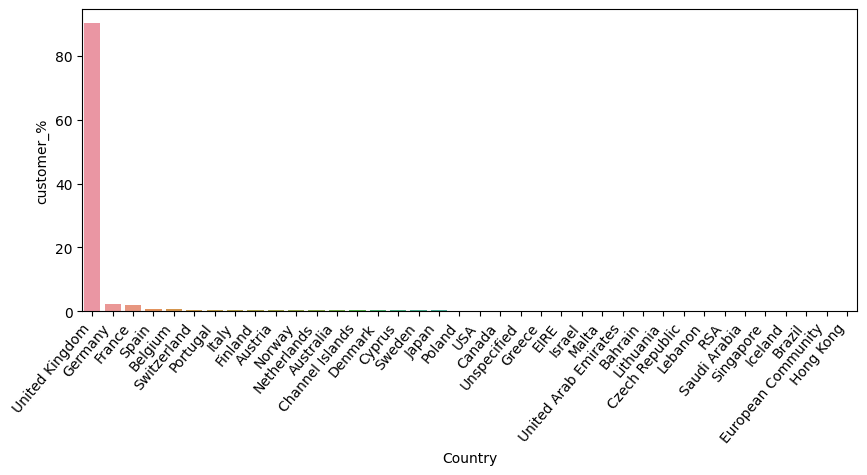

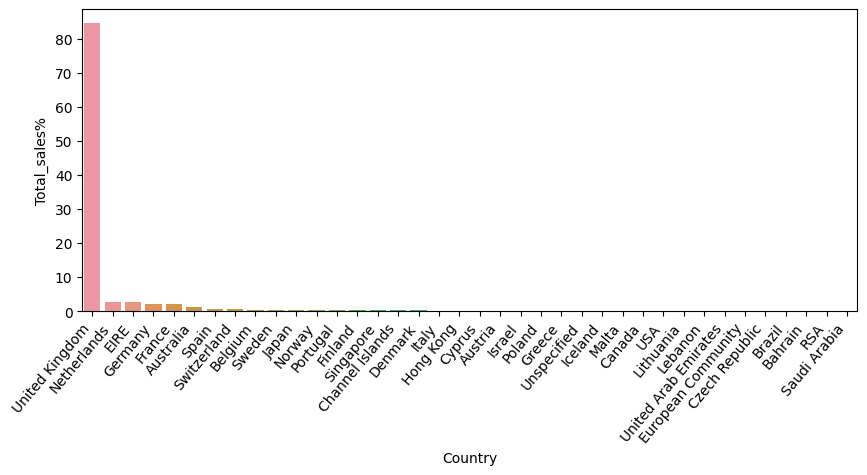

In [34]:
# COUNTRY V/S CUSTOMER %
country_customer_df = country_customer_df.sort_values(by = "customer_%", ascending = False)
fig, ax = plt.subplots(figsize = (10, 4), dpi = 100)
ax = sns.barplot(x = country_customer_df["Country"], y = country_customer_df['customer_%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 50, ha = "right")
plt.show()

# COUNTRY V/S TOTAL SALES %
country_df = country_df.sort_values(by = "Total_sales%", ascending = False)
fig, ax = plt.subplots(figsize = (10, 4), dpi = 100)
ax = sns.barplot(x = country_df["Country"], y = country_df['Total_sales%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 50, ha = "right")
plt.show()

* The United Kingdom not only has the most sales revenue, but also the most customers. Therefore, for the purpose of this analysis, I will be taking data corresponding to orders from the United Kingdom.

In [35]:
# CREATING A UK DF
uk_df = df[df.Country == "United Kingdom"]
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479985 entries, 0 to 541893
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   InvoiceNo      479985 non-null  object 
 1   StockCode      479985 non-null  object 
 2   Description    479985 non-null  object 
 3   Quantity       479985 non-null  int64  
 4   InvoiceDate    479985 non-null  object 
 5   UnitPrice      479985 non-null  float64
 6   CustomerID     349203 non-null  float64
 7   Country        479985 non-null  object 
 8   NewID          479985 non-null  int64  
 9   cancellations  479985 non-null  int64  
 10  Total_sales    479985 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 43.9+ MB


In [36]:
# CHECKING MOST POPULAR PRODUCT IN UK
uk_product = uk_df.groupby(['StockCode', 'Description'], as_index= False)['Quantity'].sum().sort_values(by = 'Quantity', ascending = False)
uk_product.head(5)

,StockCode,Description,Quantity
2653,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
2112,23166,MEDIUM CERAMIC TOP STORAGE JAR,77036
3113,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49430
3601,85099B,JUMBO BAG RED RETROSPOT,44161
3622,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35430


In [37]:
# FIND THE UNIQUE NUMBER OF InvoiceNo PER CUSTOMER FOR ANALYZING UK 
groupby_customers = pd.DataFrame(uk_df.groupby('NewID')['InvoiceNo'].nunique())
groupby_customers.describe()

,InvoiceNo
count,5293.000000
mean,3.404308
std,6.356634
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,209.000000


In [38]:
# FIND THE UNIQUE MBER OF PRODUCTS PER ORDER
groupby_invoice = pd.DataFrame(uk_df.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns = ['Number of products per Order']
groupby_invoice.describe()

,Number of products per Order
count,18019.000000
mean,26.351129
std,48.882851
min,1.000000
25%,6.000000
50%,15.000000
75%,29.000000
max,1110.000000


* The average number of orders per customer is 1 and average number of products per Order is 15

# RFM Analysis

RFM is a data modeling method used to analyze customer value. It stands for Recency, Frequency and Monetary, which are just three metrics that describe what your customers did.

* *Recency (R) of a customer* - Days since the last purchase.
* *Frequency (F) of the bookings/turnover of a customer* - Number of purchases, e.g., in 6 months.
* *Monetary (M)* - The total turnover of a customer: Sum of sales, e.g., in 6 months.

For the analysis, we need to define a ‘analysis date’, which is the day on which we are conducting this analysis which I am taking as the next to last date in data and taking 1 year previous data from the selected date for recency calculation

In [39]:
# CONVERTING THE InvoiceDate COLUMN INTO DATETIME
uk_df['InvoiceDate'] = pd.to_datetime(uk_df['InvoiceDate'])

In [40]:
# CREATING AN RFM ANALYSIS DF
analysis_date = uk_df["InvoiceDate"].max() + pd.DateOffset(1)
print("RFM Analysis Date :", analysis_date)

# START DATE FOR OUR ANALYSIS DF
start_date = analysis_date - pd.DateOffset(days = 365)
print("Start Date when taking 1 year data for analysis :", start_date)

RFM Analysis Date : 2011-12-11 17:19:00
Start Date when taking 1 year data for analysis : 2010-12-11 17:19:00


* Although, I created column to deal with CustomerID Nulls (NewID), I will now drop rows with Nulls as customerID since these fake customer ID's would skew the analysis, especially the frequency. Aggregating Remaining dataset to calculate recency, frequency and monetary value columns for every customerID

In [42]:
# DROP NULLS IN CustomerID
uk_df = uk_df[~uk_df.CustomerID.isnull()]

# AGGREGATE DATA ON A CUSTOMER LEVEL TO GET RFM VALUES
data_rfm = uk_df[uk_df.InvoiceDate >= start_date].groupby(['NewID'],as_index=False).agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
            'InvoiceNo': 'count','Total_sales': 'sum'}).rename(columns = {'InvoiceDate': 'Recency', \
                                            'InvoiceNo': 'Frequency','Total_sales': 'Monetary'})
data_rfm.head()

,NewID,Recency,Frequency,Monetary
0,123460,327,1,77183.60
1,127470,24,96,3837.45
2,127480,5,3883,29674.51
3,127490,24,199,4090.88
4,128200,46,59,942.34


In [43]:
# GETTING INDIVIDUAL RFM SCORES BY USING QUANTILES FOR EACH OF THE COLUMNS
data_rfm['R_score'] = pd.qcut(data_rfm['Recency'], 4, labels=False)
data_rfm['F_score'] = pd.qcut(data_rfm['Frequency'], 4, labels=False)
data_rfm['M_score'] = pd.qcut(data_rfm['Monetary'], 4, labels=False)

# SINCE A LOW RECENCY SCORE MEANS RECENT TRANSACTIONS AND GOOD CUSTOMER,
# CHANGING QUANTILE VALUES SO THAT LOW VALUES RANK HIGHEST AND VICE VERSA.
data_rfm['R_score'] = 3 - data_rfm['R_score']

data_rfm['RFM'] = data_rfm.R_score.map(str) \
                            + data_rfm.F_score.map(str) \
                            + data_rfm.M_score.map(str)

#ALCULATING FINAL RFM SCORE
data_rfm["RFM_Score"] = data_rfm['R_score'] + data_rfm['F_score'] + data_rfm['M_score']
data_rfm.head(10)

,NewID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM,RFM_Score
0,123460,327,1,77183.60,0,0,3,003,3
1,127470,24,96,3837.45,2,2,3,223,7
2,127480,5,3883,29674.51,3,3,3,333,9
3,127490,24,199,4090.88,2,3,3,233,8
4,128200,46,59,942.34,2,2,2,222,6
5,128210,97,6,92.72,1,0,0,100,1
6,128220,72,46,948.88,1,2,2,122,5
7,128230,76,5,1759.50,1,0,3,103,4
8,128240,31,25,397.12,2,1,1,211,4
9,128260,61,82,1319.72,2,2,2,222,6


* The RFM_Score values will range from 0 (0 + 0 + 0) to 9 (3 + 3 + 3). Now grouping by the RFM scores to check the mean values of recency, frequency and monetary corresponding to each score.

In [44]:
# GROUPING TO CHECK THE MEAN VALUES
data_rfm.groupby("RFM_Score")[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
RFM_Score,,,
0,247.649518,7.581994,146.476463
1,183.753623,13.895652,220.795188
2,160.032120,20.815846,342.064799
3,104.979638,26.667421,627.106676
4,97.309091,39.257143,1266.646987
5,66.700000,52.407317,1024.498417
6,55.210084,74.120448,1372.810087
7,40.436548,118.763959,1817.034188
8,26.517241,181.846154,3930.945623


* As expected, customers with the lowest RFM scores have the highest recency value and the lowest frequency and monetary value, and the vice-versa is true as well. This can be used to create manual segments based on RFM scores like Loyal Customers Group where Frequancy is High, High Spending Group where Monetary is High, Lost Customers Group where Recency is High etc.

* Loyal and Good Customers which have High RFM values could be rewarded and heavy discounts are not needed for them. Customers with High Recency (and High Frequency and Monetary values) could be targeted aggresively with discounts so that they are not lost

# Modeling: K - Means Clustering

* To properly find out segments on our RFM values, we can use a clustering algorithm like K-means.

------------------------------- Distribution Plots for R,F,M -------------------------------


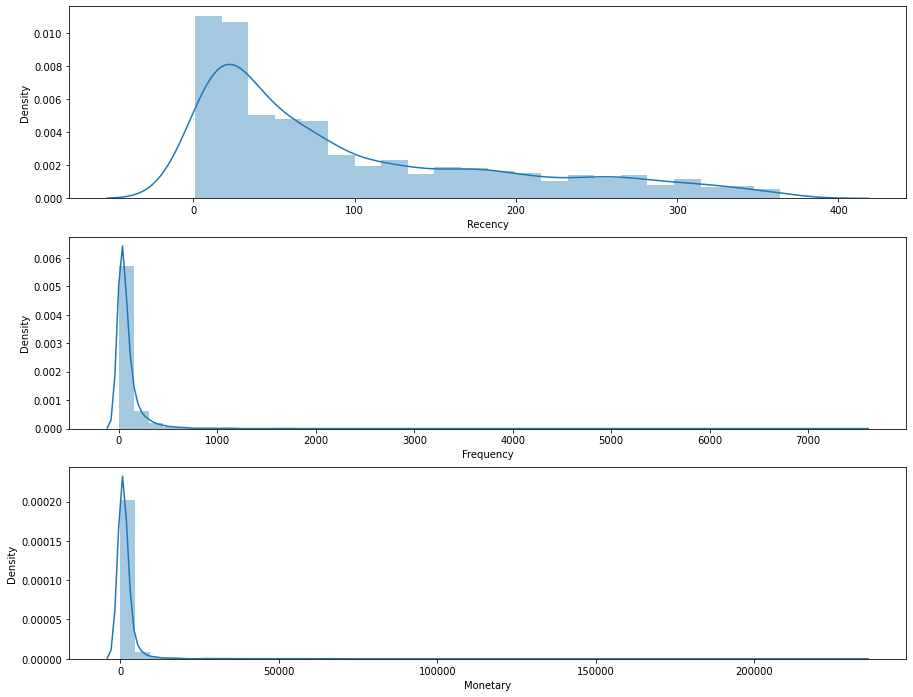

In [48]:
print("------------------------------- Distribution Plots for R,F,M -------------------------------")

# CHECKING THE DISTRIBUTION OF Recency, Frequency and Monetary VALUE VARIABLES.
plt.figure(figsize = (15, 12))

plt.subplot(3, 1, 1)
sns.distplot(data_rfm['Recency'])

plt.subplot(3, 1, 2)
sns.distplot(data_rfm['Frequency'])

plt.subplot(3, 1, 3)
sns.distplot(data_rfm['Monetary'])

* From the above figure, all the variables do not have a symmetrical distribution. All of them are skewed to the right. Since clustering algorithms require a normal distribution, normalization of the data is required. I am using Log transformation to deal with the skewness of data

------------------------------- Log Transformation Plots for R,F,M -------------------------------


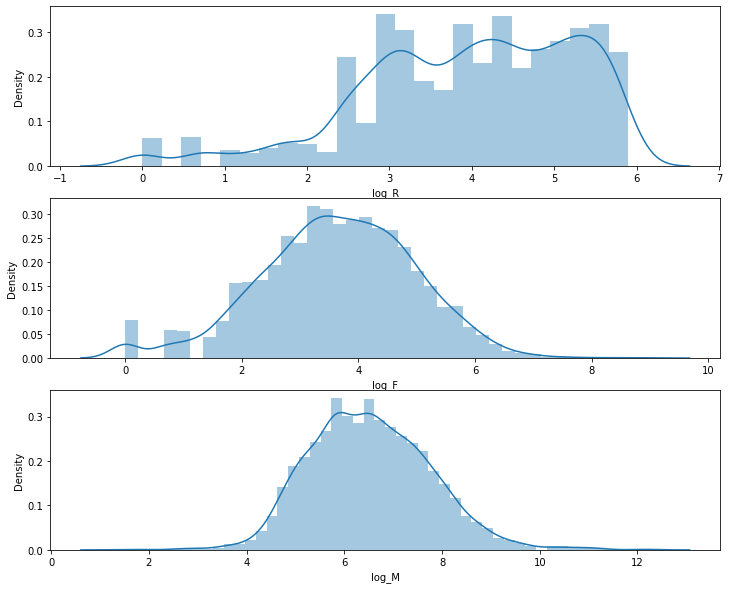

In [49]:
# TAKING LOGARITHM OF COLUMNS
data_rfm["log_R"] = np.log(data_rfm.Recency)
data_rfm["log_F"] = np.log(data_rfm.Frequency)
data_rfm["log_M"] = np.log(data_rfm.Monetary)

# CHECKING THE DISTRIBUTION OF R, F, M AGAIN
print("------------------------------- Log Transformation Plots for R,F,M -------------------------------")

plt.figure(figsize = (12, 10))

plt.subplot(3, 1, 1)
sns.distplot(data_rfm['log_R'])

plt.subplot(3, 1, 2)
sns.distplot(data_rfm['log_F'])

plt.subplot(3, 1, 3)
sns.distplot(data_rfm['log_M'])

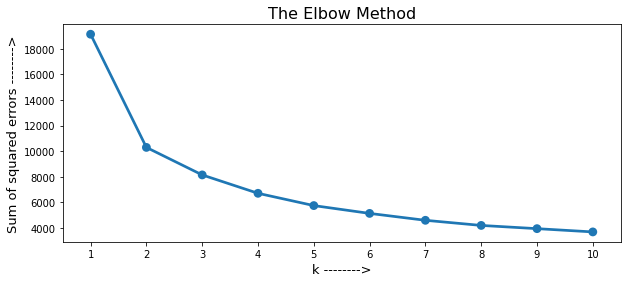

In [50]:
# FEATURES USED IN TRAINING - LOG TRANSFORMED RECENCY, FREQUANCY AND MONETARY VALUES
data_norm = data_rfm[["log_R", "log_F", "log_M"]]

sse = {}
# FIT KMEANS AND CALCULATE SSE FOR EACH K
for k in range(1, 11):
  
    # INITIALIZE KMEANS WITH K CLUSTERS
    kmeans = KMeans(n_clusters = k, random_state = 1)
    
    # FIT KMEANS ON THE NORMALIZED DATASET
    kmeans.fit(data_norm)
    
    # ASSIGN SUM OF SQUARED DISTANCES TO K ELEMENT OF DICTIONARY
    sse[k] = kmeans.inertia_
    
# PLOTTING THE ELBOW PLOT
plt.figure(figsize = (10, 4))
plt.title('The Elbow Method', size = 16)
plt.xlabel('k -------->', size = 13); 
plt.ylabel('Sum of squared errors -------->', size = 13)
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

* 
From the above plot, we can see that the optimal number of clusters can be taken as 3. Now I am building the K Means model using 3 clusters.

In [66]:
# FITTIMG OUR MODEL
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, random_state = 1)
kmeans.fit(data_norm)
data_rfm["cluster"] = kmeans.predict(data_norm)

In [67]:
# CHECKING MEAN RFM VALUES IN DIFFERENT CLUSTERS TO UNDERSTAND CLUSTER PROPERTIES
data_rfm.groupby(["cluster"])[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
cluster,,,
0,166.714512,13.103886,267.649739
1,91.150437,59.147940,1021.386438
2,20.135903,226.821501,5076.267363


* This is the mean value of RFM in different clusters. Clearly there is correlation between Frequency and Monetary - how their value varies between clusters. This can also be seen in the heat map of these three features shown below. Low value of recency means recent transactions while high frequency means more frequent transactions and high Monetary value means high spending in transactions

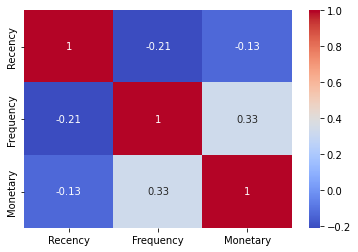

In [69]:
# CHECKING CORRELATION
sns.heatmap(data_rfm[['Recency','Frequency', 'Monetary']].corr(), cmap = "coolwarm", annot = True)

* There is a negative correlation between Recency - Frequency and Recency - Monetary, but there is a positive correlation between Frequency - Monetary which can also be seen in the variation of mean values in clusters

Text(0, 0.5, 'Monetary')

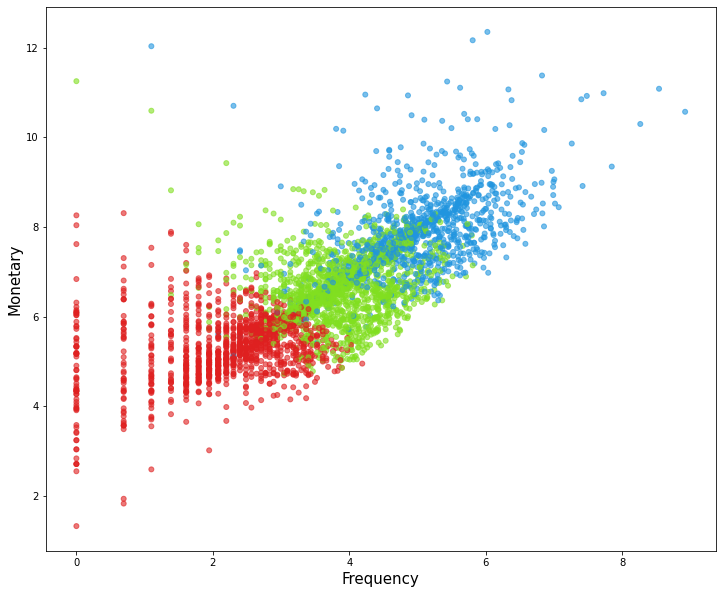

In [71]:
# GET CENTROIDS
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## ADD TO DF
data_rfm['cen_x'] = data_rfm.cluster.map({0 : cen_x[0], 1 : cen_x[1], 2 : cen_x[2]})
data_rfm['cen_y'] = data_rfm.cluster.map({0 : cen_y[0], 1 : cen_y[1], 2 : cen_y[2]})

# DEFINE AND MAP COLOURS
colors = ['#DF2020', '#81DF20', '#2095DF']
data_rfm['c'] = data_rfm.cluster.map({0 : colors[0], 1 : colors[1], 2 : colors[2]})

# PLOT CLUSTERS
plt.figure(figsize = (12, 10))
plt.scatter(data_rfm.log_F, data_rfm.log_M, c = data_rfm.c, alpha = 0.6, s = 25)
plt.xlabel('Frequency', fontsize = 15)
plt.ylabel('Monetary', fontsize = 15)